## Context and Motivation
### In this course, neural networks are not treated as black boxes but as architectural components whose design choices affect performance, scalability, and interpretability.
This assignment focuses on convolutional layers as a concrete example of how inductive bias is introduced into learning systems.

Rather than following a recipe, students will select, analyze, and experiment with a convolutional architecture using a real dataset.

## Learning Objectives

By completing this assignment, students will be able to:

- **Understand** the role and mathematical intuition behind convolutional layers.  
- **Analyze** how architectural decisions (kernel size, depth, stride, padding) affect learning.  
- **Compare** convolutional layers with fully connected layers for image-like data.  
- **Perform** a minimal but meaningful exploratory data analysis (EDA) for neural network tasks.  
- **Communicate** architectural and experimental decisions clearly.


## Dataset Selection (Student-Driven)

The dataset is not a neutral choice: it defines the difficulty of the task, the type of inductive bias we can exploit, and the computational budget required for training.

### Public sources considered
- TensorFlow Datasets (`tfds`)
- PyTorch `torchvision.datasets`
- Kaggle (only open datasets that do not require joining competitions)

### Formal constraints and why they matter
| Constraint | Requirement | Why it matters for CNN analysis |
|---|---|---|
| Data modality | Image tensors (2D or 3D) | Convolution assumes local spatial structure and channel-wise composition. |
| Label space | At least 2 classes | A single class does not allow discriminative learning or meaningful decision boundaries. |
| Compute feasibility | Must fit in memory on a laptop/cloud notebook | The focus is architectural reasoning, not distributed infrastructure engineering. |

### Memory feasibility check
A practical approximation for in-memory storage is:

$$
\text{Memory (bytes)} \approx N \cdot H \cdot W \cdot C \cdot b
$$

where $N$ is number of images, $(H, W, C)$ is tensor shape, and $b$ is bytes per pixel.

For CIFAR-10 in `float32`:

$$
60{,}000 \cdot 32 \cdot 32 \cdot 3 \cdot 4 = 737{,}280{,}000 \text{ bytes} \approx 703 \text{ MiB}
$$

This is feasible on standard environments (for example, 8-16 GB RAM), leaving room for labels, model parameters, and training buffers.

### Why CIFAR-10 is an appropriate choice
CIFAR-10 is selected because it balances **conceptual value** and **computational practicality**:
- It contains 10 classes, enabling non-trivial multi-class discrimination.
- Images are RGB (`32x32x3`), preserving spatial and channel patterns that CNNs are designed to exploit.
- It is large enough to expose the gap between dense and convolutional models, but still tractable for controlled experiments.
- It is a widely used benchmark, which supports reproducibility and interpretation.

This makes CIFAR-10 an excellent dataset for studying how convolutional inductive bias changes learning behavior.


## Dataset Constraints

To keep the assignment methodologically consistent, the dataset must satisfy all constraints below.

| Constraint | Technical interpretation | Risk if violated |
|---|---|---|
| Image-based | Samples are tensors with explicit spatial dimensions (`H x W` or `H x W x C`) | CNN assumptions become invalid or weak. |
| At least 2 classes | The task must be discriminative classification | No meaningful comparison of decision quality. |
| Fits in memory | Data loading and preprocessing should be executable in one notebook session | Training becomes unstable or impossible in common hardware settings. |

These constraints ensure that performance differences are mainly due to architecture design choices, which is the central objective of the assignment.


In [15]:
%pip install numpy matplotlib tensorflow tensorflow-datasets pandas


Note: you may need to restart the kernel to use updated packages.


In [16]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras 
from tensorflow.keras import datasets,layers,models
from tensorflow.keras.utils import to_categorical
import pandas as pd

# Dataset Selection and Justification


Image classification can be framed as learning a mapping $f_\theta: \mathcal{X} \to \mathcal{Y}$ from image tensors to class labels.

In this notebook, we choose **CIFAR-10** and justify that choice against common alternatives.

## Candidate datasets comparison
| Dataset | Image shape | Classes | Difficulty level | Suitability for this assignment |
|---|---|---|---|---|
| MNIST | `28x28x1` | 10 | Low | Good for basics, but too simple to fully expose CNN design trade-offs. |
| Fashion-MNIST | `28x28x1` | 10 | Low-Medium | Better than MNIST, still limited visual complexity. |
| CIFAR-10 | `32x32x3` | 10 | Medium | **Selected**: good balance of complexity, size, and training cost. |
| CIFAR-100 | `32x32x3` | 100 | High | Useful, but harder to analyze clearly in a first architecture study. |

## Technical reasons to select CIFAR-10
1. **Spatial structure is meaningful**: neighboring pixels are correlated; local features (edges/textures) are informative.
2. **Translation robustness is relevant**: object location can vary, so parameter sharing is beneficial.
3. **Multi-channel input**: RGB channels allow early feature fusion in convolutional filters.
4. **Controlled compute budget**: experiments can be repeated with different architectural choices.

A useful intuition is that many vision tasks satisfy an approximate local-stationarity assumption:

$$
\text{statistics of local patterns are similar across image regions}
$$

CNNs exploit this through local receptive fields and shared kernels, which is exactly what this assignment aims to analyze.


In [17]:
(X_train,Y_train),(X_test,Y_test)=datasets.cifar10.load_data()
print(X_train,Y_train)
print(X_test,Y_test)

/home/juanes/OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO/Arep/Exploring-Convolutional-Layers-Through-Data-and-Experiments/.venv/lib/python3.12/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


[[[[ 59  62  63]
   [ 43  46  45]
   [ 50  48  43]
   ...
   [158 132 108]
   [152 125 102]
   [148 124 103]]

  [[ 16  20  20]
   [  0   0   0]
   [ 18   8   0]
   ...
   [123  88  55]
   [119  83  50]
   [122  87  57]]

  [[ 25  24  21]
   [ 16   7   0]
   [ 49  27   8]
   ...
   [118  84  50]
   [120  84  50]
   [109  73  42]]

  ...

  [[208 170  96]
   [201 153  34]
   [198 161  26]
   ...
   [160 133  70]
   [ 56  31   7]
   [ 53  34  20]]

  [[180 139  96]
   [173 123  42]
   [186 144  30]
   ...
   [184 148  94]
   [ 97  62  34]
   [ 83  53  34]]

  [[177 144 116]
   [168 129  94]
   [179 142  87]
   ...
   [216 184 140]
   [151 118  84]
   [123  92  72]]]


 [[[154 177 187]
   [126 137 136]
   [105 104  95]
   ...
   [ 91  95  71]
   [ 87  90  71]
   [ 79  81  70]]

  [[140 160 169]
   [145 153 154]
   [125 125 118]
   ...
   [ 96  99  78]
   [ 77  80  62]
   [ 71  73  61]]

  [[140 155 164]
   [139 146 149]
   [115 115 112]
   ...
   [ 79  82  64]
   [ 68  70  55]
   [ 67  69

# 1. Dataset Exploration (EDA)

The objective of this EDA is **structural understanding**, not exhaustive descriptive statistics.

## EDA questions and modeling impact
| EDA question | Evidence collected | Why it matters for modeling |
|---|---|---|
| How many samples are available? | Train/test counts | Defines statistical reliability and expected variance. |
| Are classes balanced? | Class frequencies and percentages | Imbalance can bias gradients and reported accuracy. |
| What is the input geometry? | Image size and channels | Directly determines input layer design and parameter count. |
| Is preprocessing required? | Pixel value range and dtype | Affects optimization stability and convergence speed. |
| Are labels visually coherent? | Example images per class | Detects data issues before expensive training. |

This EDA supports principled model design decisions in the baseline and CNN sections.


### Pixel Scaling and Normalization


**Purpose**  
Convert raw pixel values to a numerically stable range for optimization.

**Transformation used**

$$
x' = \frac{x}{255}
$$

where $x \in [0,255]$ and therefore $x' \in [0,1]$.

**Why this is appropriate here**
- It keeps gradients in a healthier scale for Adam optimization.
- It is simple and reproducible.
- For CIFAR-10 baseline/CNN comparisons, min-max scaling is sufficient.

**Alternative (not required in this notebook)**

$$
\tilde{x} = \frac{x - \mu}{\sigma}
$$

(channel-wise standardization), which can further stabilize training in deeper settings.


In [18]:
X_train=X_train.astype("float32")/255.0
X_test=X_test.astype("float32")/255.0
y_train_int = Y_train.squeeze()
y_test_int  = Y_test.squeeze()

### Dataset Size and Split Integrity


**Purpose**  
Validate that sample counts are consistent with the expected benchmark split.

| Split | Expected samples | Observed in notebook | Status |
|---|---:|---:|---|
| Train | 50,000 | 50,000 | OK |
| Test | 10,000 | 10,000 | OK |

With a validation fraction of $0.1$, the effective optimization set is:

$$
N_{train,eff} = 50{,}000 \cdot (1-0.1) = 45{,}000
$$

For batch size $B=64$, the number of steps per epoch is approximately:

$$
\left\lceil \frac{45{,}000}{64} \right\rceil = 704
$$

This is useful to estimate training time and compare runtime between architectures.


In [19]:
print("X_train:", X_train.shape, X_train.dtype, "range:", X_train.min(), X_train.max())
print("y_train:", y_train_int.shape, y_train_int.dtype)



X_train: (50000, 32, 32, 3) float32 range: 0.0 1.0
y_train: (50000,) uint8


### Class Distribution and Balance


**Purpose**  
Determine whether class imbalance might bias optimization and evaluation.

Let $n_k$ be samples in class $k$ and $N$ total samples. Class prior is:

$$
p_k = \frac{n_k}{N}
$$

For CIFAR-10 train split, $n_k = 5{,}000$ for all 10 classes, so:

$$
p_k = 0.1 \quad \forall k
$$

This is an ideal balanced scenario. In information terms, class entropy reaches its maximum for $K=10$:

$$
H(Y) = -\sum_{k=1}^{K} p_k \log p_k = \log(10)
$$

Therefore, plain accuracy is a reasonable first metric without class-weight corrections.


In [20]:
labels =pd.Series(Y_train.squeeze(),name="label")
counts=labels.value_counts().sort_index()
percentajes=labels.value_counts(normalize=True).sort_index()

print(counts)
print(percentajes)

label
0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: count, dtype: int64
label
0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: proportion, dtype: float64


### Visual Inspection: Samples per Class


**Purpose**  
Perform a qualitative sanity check before training.

**What this verifies**
- Label-image consistency for each class.
- Natural intra-class variability (pose, background, illumination).
- Absence of obvious corruption or preprocessing artifacts.

**Why this matters**
Quantitative summaries can look correct even when visual data quality is poor. A lightweight visual audit reduces the risk of training on silently broken data.


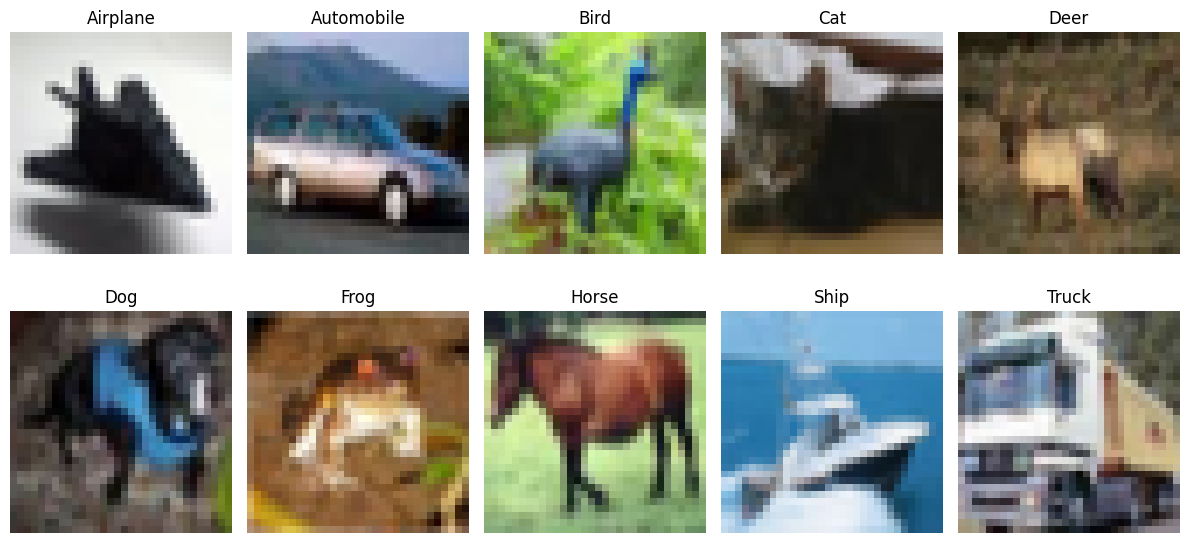

In [21]:
class_names = ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for cls in range(10):
    idx = np.where(Y_train == cls)[0][0]  
    axes[cls].imshow(X_train[idx])
    axes[cls].set_title(class_names[cls])
    axes[cls].axis("off")

plt.tight_layout()
plt.show()

# 2. Baseline Model (Non-Convolutional)

A dense baseline is intentionally built as a reference point before introducing convolution.

## Baseline architecture
| Layer | Input -> Output | Parameters |
|---|---|---:|
| Flatten | `32x32x3 -> 3072` | 0 |
| Dense + ReLU | `3072 -> 512` | $(3072+1)\cdot512 = 1,573,376$ |
| Dropout (0.3) | `512 -> 512` | 0 |
| Dense + ReLU | `512 -> 256` | $(512+1)\cdot256 = 131,328$ |
| Dense + Softmax | `256 -> 10` | $(256+1)\cdot10 = 2,570$ |
| **Total** |  | **1,707,274** |

Dense-layer parameter rule:

$$
\#\text{params}_{dense} = (n_{in}+1)\cdot n_{out}
$$

## Why this baseline is important
- It gives a fair non-convolutional reference for accuracy and loss.
- It quantifies the cost of ignoring spatial locality.
- It supports a causal argument: any CNN gain can be interpreted relative to this baseline.

## Reported performance in this notebook run
| Metric | Value |
|---|---:|
| Final train accuracy (epoch 15) | 0.3964 |
| Final validation accuracy (epoch 15) | 0.3880 |
| Best validation accuracy (observed) | 0.4178 |
| Test accuracy | 0.3993 |
| Test loss | 1.6869 |

## Observed limitations
1. Flattening destroys 2D locality, so the model cannot exploit nearby-pixel structure efficiently.
2. Fully connected layers are parameter-heavy and still underperform on this vision task.
3. Generalization remains limited, which motivates the CNN architecture.


In [22]:
rng=np.random.default_rng(42)
idx=rng.permutation(len(X_train))

X_train,Y_train=X_train[idx],Y_train[idx]
val_frac=0.1
n_val=int(len(X_train)*val_frac)

X_val,Y_val=X_train[:n_val],Y_train[:n_val]

X_tr,Y_tr=X_train[n_val:],Y_train[n_val:]


In [23]:
baseline = keras.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Flatten(),                         
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [24]:
baseline.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
    
)

baseline.summary()
print("Total params:",baseline.count_params())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,274 (6.51 MB)

 Trainable params: 1,707,274 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

Total params: 1707274


In [25]:
histoty=baseline.fit(
    X_tr,Y_tr,
    epochs=15,
    batch_size=64,
    validation_data=(X_val,Y_val),
    verbose=2
)
test_loss, test_acc = baseline.evaluate(X_test, Y_test, verbose=0)
print("Test acc:", test_acc, "Test loss:", test_loss)

Epoch 1/15
704/704 - 24s - 34ms/step - loss: 1.9972 - sparse_categorical_accuracy: 0.2650 - val_loss: 1.8568 - val_sparse_categorical_accuracy: 0.3254
Epoch 2/15
704/704 - 21s - 29ms/step - loss: 1.8770 - sparse_categorical_accuracy: 0.3099 - val_loss: 1.7982 - val_sparse_categorical_accuracy: 0.3492
Epoch 3/15
704/704 - 24s - 34ms/step - loss: 1.8366 - sparse_categorical_accuracy: 0.3261 - val_loss: 1.7621 - val_sparse_categorical_accuracy: 0.3692
Epoch 4/15
704/704 - 39s - 56ms/step - loss: 1.8057 - sparse_categorical_accuracy: 0.3396 - val_loss: 1.7945 - val_sparse_categorical_accuracy: 0.3408
Epoch 5/15
704/704 - 21s - 30ms/step - loss: 1.7878 - sparse_categorical_accuracy: 0.3466 - val_loss: 1.7224 - val_sparse_categorical_accuracy: 0.3820
Epoch 6/15
704/704 - 22s - 31ms/step - loss: 1.7656 - sparse_categorical_accuracy: 0.3564 - val_loss: 1.7149 - val_sparse_categorical_accuracy: 0.3924
Epoch 7/15
704/704 - 40s - 57ms/step - loss: 1.7508 - sparse_categorical_accuracy: 0.3638 - va

# 3. Convolutional Architecture Design

The CNN is designed from scratch with explicit architectural intent.

## Core convolution equations
For a convolutional filter bank:

$$
y_{i,j,f} = b_f + \sum_{u=1}^{K_h}\sum_{v=1}^{K_w}\sum_{c=1}^{C_{in}} W_{u,v,c,f}\,x_{i+u, j+v, c}
$$

Spatial output size is:

$$
H_{out} = \left\lfloor \frac{H + 2P - K_h}{S} \right\rfloor + 1, \qquad
W_{out} = \left\lfloor \frac{W + 2P - K_w}{S} \right\rfloor + 1
$$

With `same` padding and stride $S=1$, spatial dimensions are preserved before pooling.

## Implemented architecture and parameterization
| Stage | Layer | Output shape | Parameters |
|---|---|---|---:|
| Input | Image tensor | `32x32x3` | 0 |
| Block 1 | Conv2D(32, 3x3, same, ReLU) | `32x32x32` | 896 |
|  | Conv2D(32, 3x3, same, ReLU) | `32x32x32` | 9,248 |
|  | MaxPool2D(2x2) | `16x16x32` | 0 |
| Block 2 | Conv2D(64, 3x3, same, ReLU) | `16x16x64` | 18,496 |
|  | Conv2D(64, 3x3, same, ReLU) | `16x16x64` | 36,928 |
|  | MaxPool2D(2x2) | `8x8x64` | 0 |
| Block 3 | Conv2D(128, 3x3, same, ReLU) | `8x8x128` | 73,856 |
| Head | GlobalAveragePooling2D | `128` | 0 |
|  | Dense(128, ReLU) | `128` | 16,512 |
|  | Dropout(0.3) | `128` | 0 |
|  | Dense(10, Softmax) | `10` | 1,290 |
| **Total** |  |  | **157,226** |

Convolution parameter rule:

$$
\#\text{params}_{conv} = (K_h \cdot K_w \cdot C_{in} + 1)\cdot C_{out}
$$

## Design rationale
1. **3x3 kernels**: strong local feature extraction with moderate compute cost.
2. **Stacked conv blocks**: progressively learn low-level to high-level representations.
3. **Max pooling**: controlled downsampling to reduce spatial resolution and computation.
4. **Global average pooling**: reduces dense-head parameters and overfitting risk compared with flattening.
5. **ReLU + Dropout**: stable optimization with regularization.

## Baseline vs CNN capacity perspective
- Baseline parameters: **1,707,274**
- CNN parameters: **157,226**

Despite having about **10.9x fewer parameters**, the CNN is expected to generalize better on image data because its inductive bias matches the spatial nature of the task.


In [26]:
model =tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu",input_shape=(32,32,3)),
    tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"),
    tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

     tf.keras.layers.Conv2D(128,(3,3),padding="same",activation="relu"),

    tf.keras.layers.GlobalAveragePooling2D(),                    
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax")

])

/home/juanes/OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO/Arep/Exploring-Convolutional-Layers-Through-Data-and-Experiments/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


model.summary()
print("Total params:",model.count_params())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,226 (614.16 KB)

 Trainable params: 157,226 (614.16 KB)

 Non-trainable params: 0 (0.00 B)

Total params: 157226


In [29]:

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=4,
        restore_best_weights=True
    )
]
history = model.fit(
    X_tr, Y_tr,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=callbacks,
    verbose=2
)


Epoch 1/30
704/704 - 187s - 265ms/step - accuracy: 0.5029 - loss: 1.3436 - val_accuracy: 0.5198 - val_loss: 1.2780
Epoch 2/30
704/704 - 182s - 259ms/step - accuracy: 0.5767 - loss: 1.1627 - val_accuracy: 0.5988 - val_loss: 1.1201
Epoch 3/30
704/704 - 183s - 260ms/step - accuracy: 0.6273 - loss: 1.0419 - val_accuracy: 0.6260 - val_loss: 1.0229
Epoch 4/30
704/704 - 185s - 263ms/step - accuracy: 0.6573 - loss: 0.9561 - val_accuracy: 0.6748 - val_loss: 0.8994
Epoch 5/30
704/704 - 183s - 260ms/step - accuracy: 0.6839 - loss: 0.8902 - val_accuracy: 0.6850 - val_loss: 0.8717
Epoch 6/30
704/704 - 196s - 279ms/step - accuracy: 0.7073 - loss: 0.8251 - val_accuracy: 0.7044 - val_loss: 0.8138
Epoch 7/30
704/704 - 181s - 257ms/step - accuracy: 0.7285 - loss: 0.7702 - val_accuracy: 0.7142 - val_loss: 0.7713
Epoch 8/30
704/704 - 203s - 288ms/step - accuracy: 0.7462 - loss: 0.7286 - val_accuracy: 0.7272 - val_loss: 0.7618
Epoch 9/30
704/704 - 182s - 258ms/step - accuracy: 0.7647 - loss: 0.6765 - val_a